# Importing

In [1]:
!ls

Logs  Users  projects


In [2]:
%cd projects/BRATS_3D/

/mnt/batch/tasks/shared/LS_root/mounts/clusters/e4ds-v4/code/projects/BRATS_3D


In [3]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
import numpy as np
from glob import glob

# Sample data load

In [9]:
BASE_DIR = "./brats2023_data"
TRAIN_DIR = os.path.join(BASE_DIR, "ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData")
TEST_DIR = os.path.join(BASE_DIR, "ASNR-MICCAI-BraTS2023-GLI-Challenge-ValidationData")

In [24]:
class BraTSDataset(Dataset):
    def __init__(self, root, is_train=True):
        self.is_train = is_train
        self.cases = sorted([d for d in glob(os.path.join(root, "*")) if os.path.isdir(d)])
        # print(f"Loaded {len(self.cases)} cases from {root}")

    def __len__(self):
        return len(self.cases)

    def load_nifiti(self, path):
        return nib.load(path).get_fdata().astype(np.float32)
    
    def __getitem__(self, idx):
        case = self.cases[idx]

        t1 = self.load_nifiti(glob(os.path.join(case, "*-t1n.nii.gz"))[0])
        t1ce = self.load_nifiti(glob(os.path.join(case, "*-t1c.nii.gz"))[0])
        t2 = self.load_nifiti(glob(os.path.join(case, "*-t2w.nii.gz"))[0])
        flair = self.load_nifiti(glob(os.path.join(case, "*-t2f.nii.gz"))[0])

        image = np.stack([t1, t1ce, t2, flair])

        sample = {'image': image}
        
        if self.is_train:
            seg = self.load_nifiti(glob(os.path.join(case, "*-seg.nii.gz"))[0])
            sample["mask"] = torch.tensor(seg)
        
        return sample

In [25]:
train_ds = BraTSDataset(TRAIN_DIR, is_train=True)
val_ds = BraTSDataset(TEST_DIR, is_train=False)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=2)

### Test

In [27]:
batch = next(iter(train_loader))
print(batch["image"].shape)
print(batch["mask"].shape)

torch.Size([2, 4, 240, 240, 155])
torch.Size([2, 240, 240, 155])


# Visualizing and understanding the BraTS ds

In [40]:
import matplotlib.pyplot as plt
import torch

In [47]:
sample = train_ds[0]
image = batch["image"]
mask = batch["mask"]
image.shape

torch.Size([2, 4, 240, 240, 155])

In [51]:
# selecting a middle slice for visualization
slice_idx = image.shape[-1] // 2

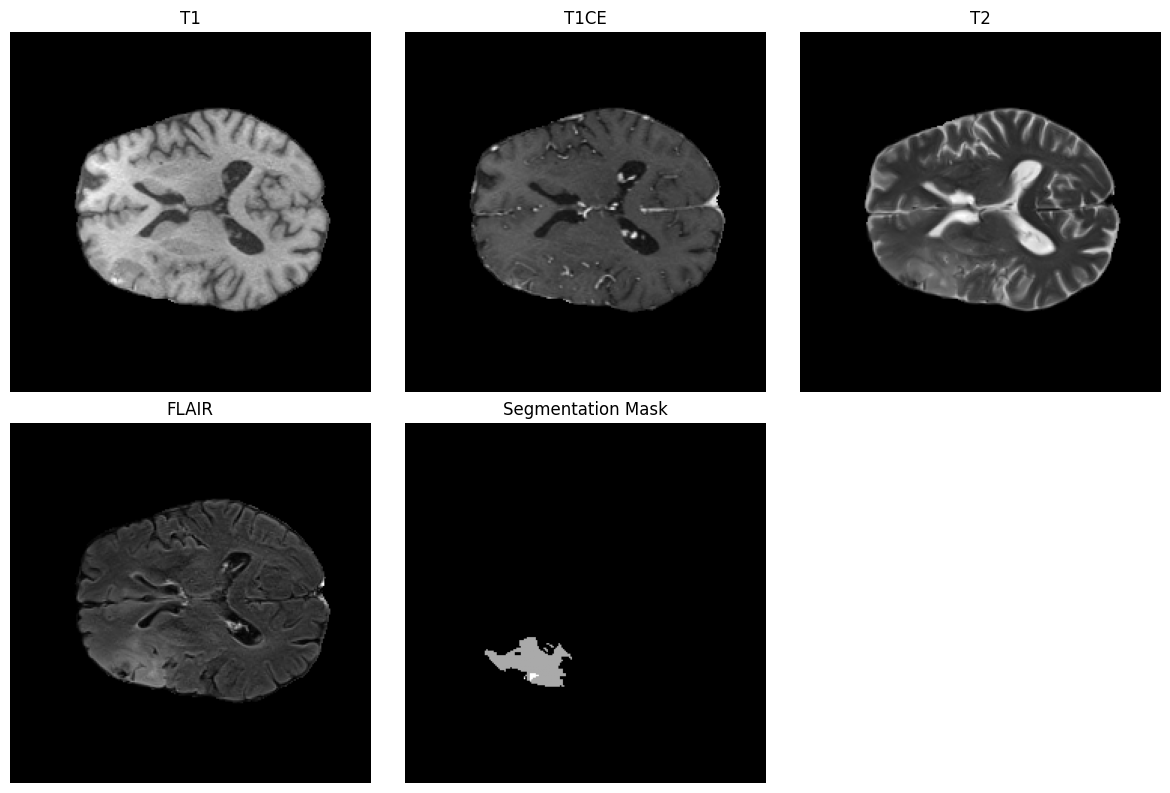

In [59]:
modalities = ["T1", "T1CE", "T2", "FLAIR"]

plt.figure(figsize=(12, 8))

for i in range(4):
    plt.subplot(2, 3, i+1)
    plt.title(modalities[i])
    plt.imshow(image[0, i, :, :, slice_idx], cmap='gray')
    plt.axis('off')
    
plt.subplot(2, 3, 5)
plt.title("Segmentation Mask")
plt.imshow(mask[0, :, :, slice_idx], cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()